In [1]:
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from lib.iux001 import fetch_data, aggregation_data
from lib.aux001 import calc_expression
from lib.cux001 import FactorEvaluate1

In [3]:
method = 'cicso0'
instruments = 'ims'
period = 5
datasets = ['train', 'val']

In [4]:
total_data = fetch_data(method=method,
                        instruments=instruments,
                        datasets=datasets)

./records/cicso0/ims/level2/train_data.feather


./records/cicso0/ims/level2/val_data.feather
./records/cicso0/ims/returns/train_returns.feather
./records/cicso0/ims/returns/val_returns.feather


In [5]:
total_data.head()

,trade_time,symbol,open,high,low,close,volume,money,twap,pct_change,...,realized_volatility,code,nxt1_ret_1h,nxt1_ret_2h,nxt1_ret_3h,nxt1_ret_5h,nxt1_ret_10h,nxt1_ret_15h,time_weight,equal_weight
0,2022-07-25 09:31:00,IM2208,6971.8,6994.8,6964.4,6973.8,602,840545880.0,6981.585000,0.000287,...,0.002546,IM,0.000498,0.000926,0.002696,0.003720,0.001397,0.001650,0.001007,0.001374
1,2022-07-25 09:32:00,IM2208,6973.8,6995.2,6969.6,6982.8,428,597671840.0,6982.126050,0.001291,...,0.001839,IM,0.000428,0.002198,0.002777,0.002744,0.001638,-0.000076,0.001409,0.001801
2,2022-07-25 09:33:00,IM2208,6982.8,6989.8,6981.6,6989.8,280,391195160.0,6985.326496,0.001002,...,0.001727,IM,0.001770,0.002349,0.002794,0.003311,0.000932,-0.000296,0.002134,0.002304
3,2022-07-25 09:34:00,IM2208,6989.6,6993.0,6982.6,6993.0,319,445873560.0,6988.716949,0.000486,...,0.001665,IM,0.000579,0.001023,0.000546,0.001704,-0.000473,-0.003404,0.000721,0.000716
4,2022-07-25 09:35:00,IM2208,6993.6,7009.0,6991.8,7002.2,284,397659840.0,6999.337288,0.001230,...,0.001700,IM,0.000445,-0.000033,0.000962,0.000182,-0.000986,-0.005230,0.000372,0.000458


In [6]:
total_data.filter(regex="^nxt1").columns.to_list()
nxt1_columns = total_data.filter(regex="^nxt1").columns.to_list()
basic_columns = [
        'close', 'high', 'low', 'open', 'value', 'volume', 'openint'
    ]

regex_pattern = r'^[^_]+_(5|10|15)_.*'
not_columns = total_data.columns[total_data.columns.str.contains(
        regex_pattern)]

factor_columns = [
        col for col in total_data.columns
        if col not in ['trade_time', 'code'] + nxt1_columns + basic_columns +
        not_columns.tolist()
    ]#[0:100]

In [7]:
total_data = total_data[['trade_time', 'code'] + factor_columns + ["nxt1_ret_{}h".format(period)]]
total_data.head()

,trade_time,code,symbol,money,twap,pct_change,pct_change_close,pct_change_set,tick_in,tick_out,...,depth_imbalance_0,depth_imbalance_1,depth_imbalance_2,depth_imbalance_3,depth_imbalance_4,ask_bid_press,realized_volatility,time_weight,equal_weight,nxt1_ret_5h
0,2022-07-25 09:31:00,IM,IM2208,840545880.0,6981.585000,0.000287,0.002472,0.005711,55,65.0,...,0.048350,0.032361,0.080896,0.116902,-0.009520,0.191198,0.002546,0.001007,0.001374,0.003720
1,2022-07-25 09:32:00,IM,IM2208,597671840.0,6982.126050,0.001291,0.003766,0.007009,59,60.0,...,0.077734,0.073275,0.029830,0.017027,0.020993,0.243969,0.001839,0.001409,0.001801,0.002744
2,2022-07-25 09:33:00,IM,IM2208,391195160.0,6985.326496,0.001002,0.004772,0.008018,54,63.0,...,0.072032,0.123311,0.126821,0.172182,0.129718,0.337424,0.001727,0.002134,0.002304,0.003311
3,2022-07-25 09:34:00,IM,IM2208,445873560.0,6988.716949,0.000486,0.005232,0.008480,55,63.0,...,-0.014664,-0.053867,0.042050,-0.065601,-0.069451,-0.099565,0.001665,0.000721,0.000716,0.001704
4,2022-07-25 09:35:00,IM,IM2208,397659840.0,6999.337288,0.001230,0.006555,0.009806,62,56.0,...,0.056584,0.106953,0.097129,0.101817,0.024232,0.132744,0.001700,0.000372,0.000458,0.000182


In [57]:
expression = "WMA(2,WMA(3,WMA(2,'pct_change')))"

In [58]:
factor_data = calc_expression(expression=expression,
                              total_data=total_data.set_index('trade_time'))

In [59]:
factor_data.head()

,trade_time,transformed,code
0,2022-07-25 09:32:00,0.000393,IM
1,2022-07-25 09:33:00,0.000780,IM
2,2022-07-25 09:34:00,0.000870,IM
3,2022-07-25 09:35:00,0.000881,IM
4,2022-07-25 09:36:00,0.000815,IM


In [60]:
dt = aggregation_data(factor_data=factor_data,
                      returns_data=total_data,
                      period=period)

In [61]:
dt.tail()

,trade_time,transformed,code,nxt1_ret_5h
137566,2024-12-04 10:20:00,-0.000450,IM,-0.001519
137571,2024-12-04 10:25:00,-0.000231,IM,0.001102
137576,2024-12-04 10:30:00,0.000128,IM,0.003080
137581,2024-12-04 10:35:00,0.000355,IM,-0.000537
137586,2024-12-04 10:40:00,-0.000149,IM,-0.001678


In [62]:
evaluate1 = FactorEvaluate1(factor_data=dt,
                                factor_name='transformed',
                                ret_name='nxt1_ret_{0}h'.format(period),
                                roll_win=240,
                                fee=0.000,
                                scale_method='roll_zscore',
                                expression=expression)

In [63]:
stats_dt = evaluate1.run()

In [64]:
stats_dt

{'total_ret': 0.3696359898410717,
 'avg_ret': 1.191600686526574e-05,
 'max_dd': -0.0457617946284411,
 'calmar': 8.077392786762383,
 'sharpe1': 0.014444960794889081,
 'sharpe2': 1.5003778398185903,
 'turnover': 0.3551941916192898,
 'win_rate': 0.49855907780979825,
 'profit_ratio': 1.06690465529602,
 'ic_mean': -0.02508221431226255,
 'ic_std': 0.0682258489780977,
 'ic_ir': -0.36763506336600665,
 'factor_autocorr': -0.020602981041731874,
 'ret_autocorr': -0.0786479291849256}

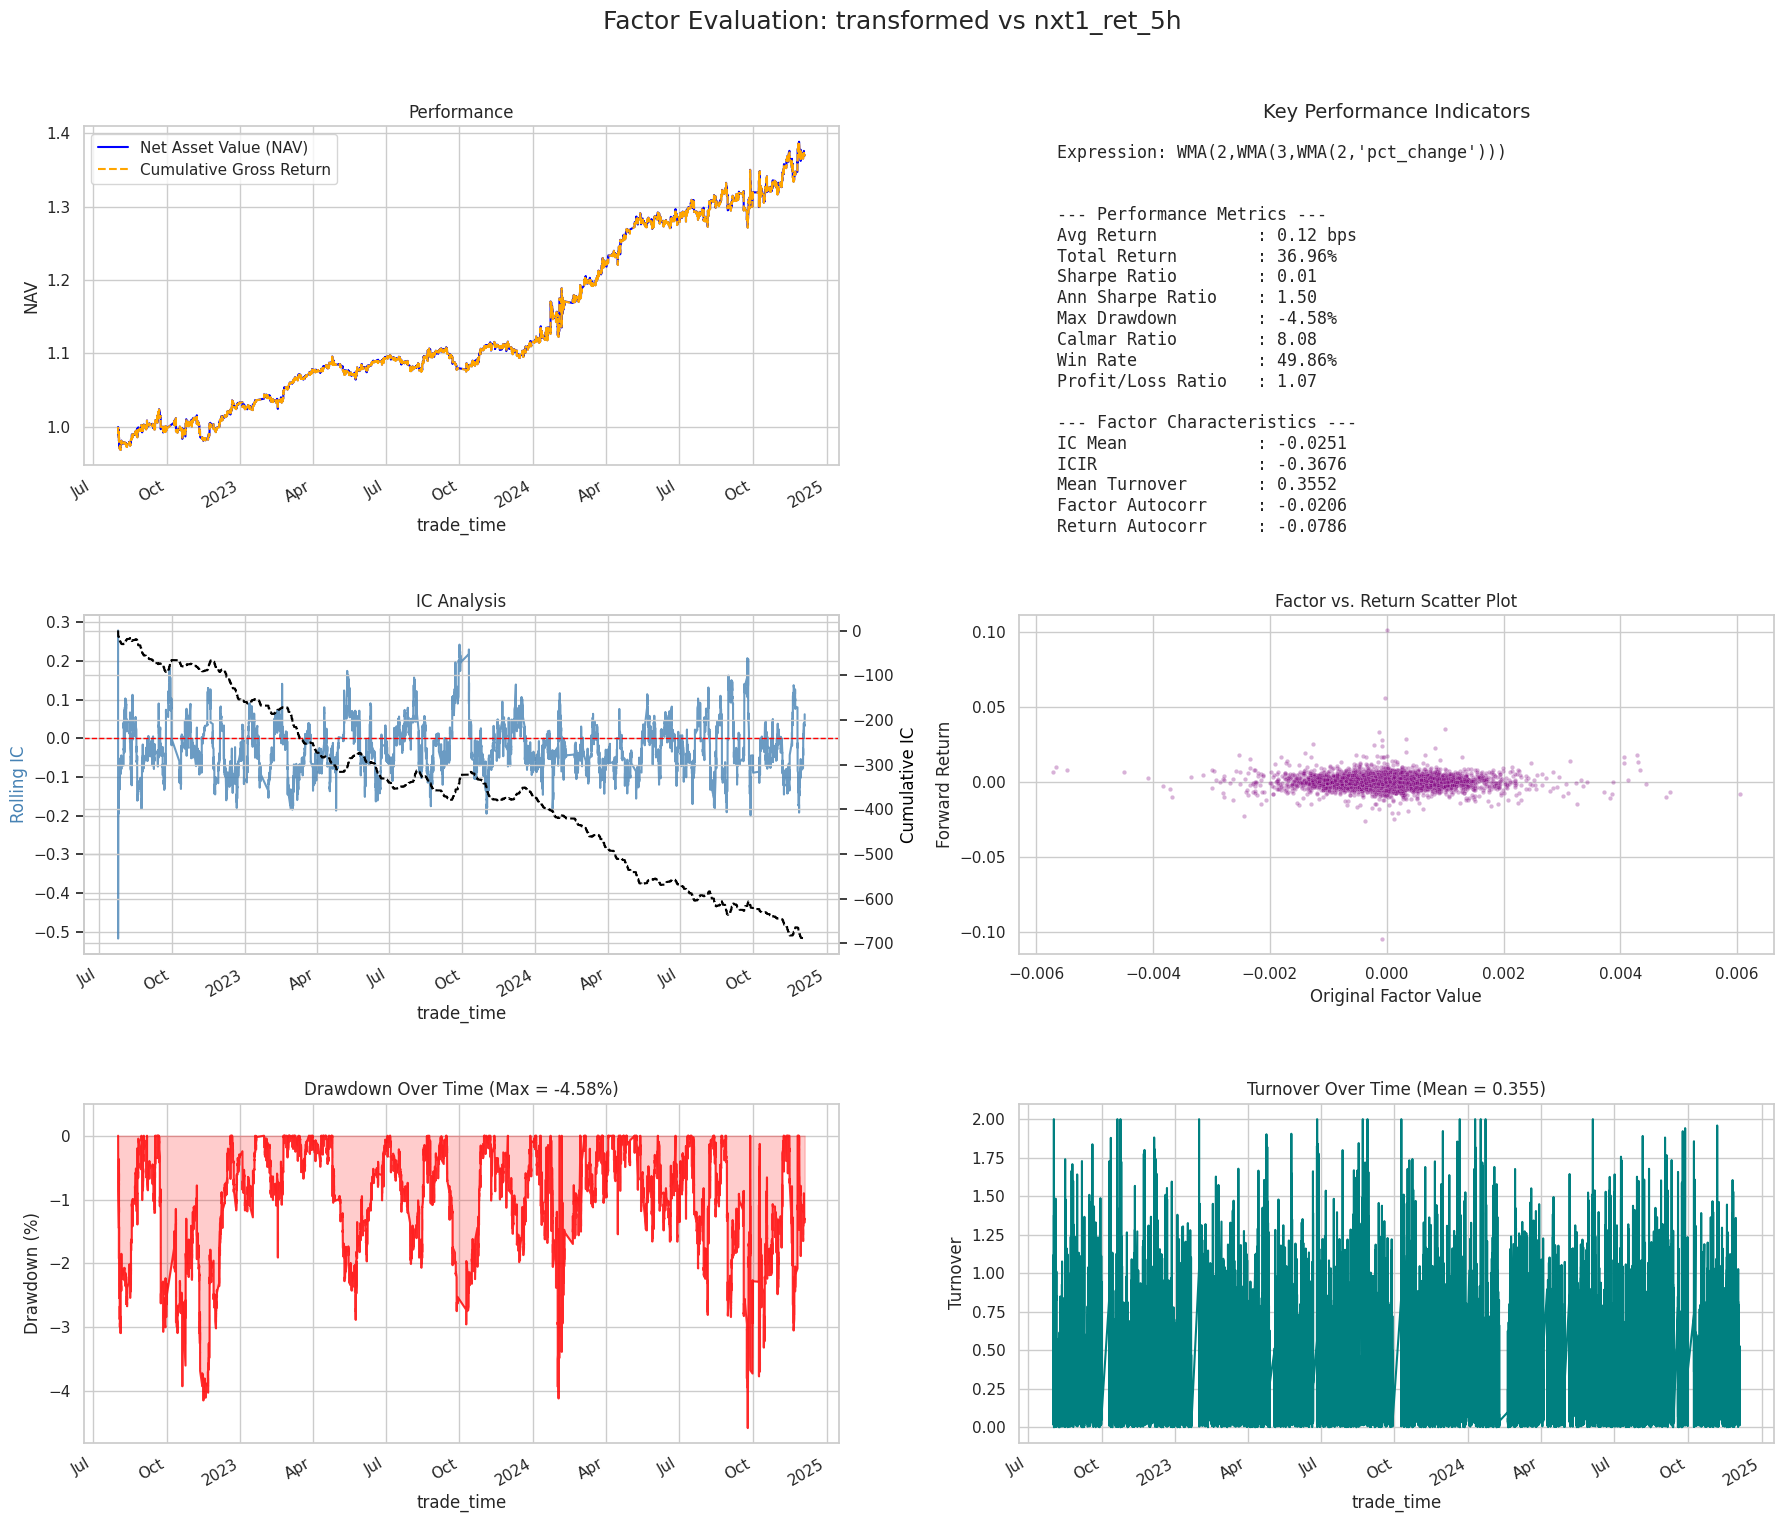

In [65]:
evaluate1.plot_results()